# Wstęp

RFM to tradycyjne podejście do analizy zachowań klientów w branży detalicznej; akronim oznacza: niedawność (ang. recency), częstotliwość (ang. frequency) (zakupu), pieniężny (ang. monetary). Ten rodzaj analizy dzieli klientów na grupy na podstawie tego, jak niedawno dokonali zakupu, jak często robią zakupy i ile wydali pieniędzy. Analiza RFM bazuje na prostych założeniach, które można dopasować do wielu gałęzi przemysłu oraz sytuacji.

Zaimportowanie plików i bibliotek:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
%matplotlib inline

In [2]:
customers = pd.read_csv("dane\customer.txt", sep='\t')

In [3]:
orders = pd.read_csv("dane\orders.txt", encoding='cp1251', sep='\t')
orders['orderdate'] = pd.to_datetime(orders['orderdate'])

In [4]:
customers.head(3)

,customerid,householdid,gender,firstname
0,174596,53949999,M,DANIEL
1,68239,49927024,M,JIM
2,10203,20914414,F,DONNA


In [5]:
orders.head()

,orderid,customerid,campaignid,orderdate,city,state,zipcode,paymenttype,totalprice,numorderlines,numunits
0,1002854,45978,2141,2009-10-13,NEWTON,MA,02459,VI,190.00,3,3
1,1002855,125381,2173,2009-10-13,NEW ROCHELLE,NY,10804,VI,10.00,1,1
2,1002856,103122,2141,2011-06-02,MIAMI,FL,33137,AE,35.22,2,2
3,1002857,130980,2173,2009-10-14,E RUTHERFORD,NJ,07073,AE,10.00,1,1
4,1002886,48553,2141,2010-11-19,BALTIMORE,MD,21218,VI,10.00,1,1


# Recency

Recency (niedawność) to czas od ostatniego zakupu.

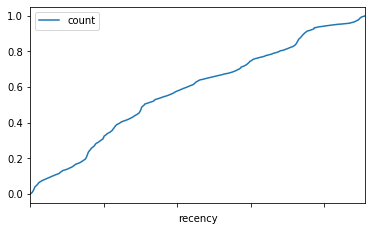

In [6]:
recencies = pd.merge(orders[orders.orderdate < '2016-01-01'], customers, on='customerid').groupby('householdid').aggregate({
        'orderdate': 'max'
    }).transform(
        lambda x: pd.to_datetime('2016-01-01') - x
    ).rename(columns={'orderdate':'recency'})
recencies['householdid'] = recencies.index
recencies = recencies.groupby('recency').count()
recencies = recencies.rename(columns={'householdid': 'count'})
recencies['count'] = recencies['count'].cumsum()
recencies['count'] = recencies['count'] / max(recencies['count'])
recencies.plot()

Wykres pokazuje histogram aktualności od daty granicznej 1 stycznia 2016 r. (zamówienia po tej dacie są ignorowane). Ten wykres pokazuje, że 20% gospodarstw domowych złożyło zamówienie w ciągu poprzednich 380 dni.

In [7]:
recencies_bins = pd.merge(orders[orders.orderdate < '2016-01-01'], customers, on='customerid').groupby('householdid').aggregate({
        'orderdate': 'max'
    }).transform(
        lambda x: pd.to_datetime('2016-01-01') - x
    ).transform(
        lambda x: pd.qcut(x, 5, labels=False)
    ).transform(lambda x: x + 1).rename(columns={'orderdate':'recency'})

recencies_bins

,recency
householdid,
18111489,4
18111580,2
18111642,2
18111668,3
18111771,5
...,...
81808143,1
81808258,1
81808290,1


# Frequency

Frequency (częstotliwość) to szybkość, z jaką klienci dokonują zakupów, obliczana jako długość czasu od pierwszego zakupu podzielona przez liczbę zakupów.

In [8]:
frequencies = pd.merge(orders[orders.orderdate < '2016-01-01'], customers, on='customerid').groupby('householdid').aggregate({
        'orderdate': 'min',
        'orderid': 'count'
    }).rename(columns={'orderdate':'mindate', 
                        'orderid': 'numorders'})
frequencies['mindate'] = pd.to_datetime('2016-01-01') - frequencies['mindate']
frequencies['frequency'] = np.floor(frequencies['mindate'].dt.days / frequencies['numorders'])
frequencies = frequencies[['frequency']]

frequencies

,frequency
householdid,
18111489,1587.0
18111580,417.0
18111642,437.0
18111668,697.0
18111771,1812.0
...,...
81808143,368.0
81808258,14.0
81808290,53.0


In [9]:
frequencies_bins = frequencies.transform(
        lambda x: pd.qcut(x, 5, labels=False)
    ).transform(lambda x: x + 1)

frequencies_bins

,frequency
householdid,
18111489,4
18111580,2
18111642,2
18111668,3
18111771,5
...,...
81808143,1
81808258,1
81808290,1


# Monetary

Ostatnia zmienna RFM jest zmienną pieniężną. Tradycyjnie jest to łączna kwota pieniędzy wydawanych przez gospodarstwa domowe. Jednak ta definicja jest zwykle silnie skorelowana z częstotliwością, ponieważ klienci, którzy dokonują więcej zakupów, mają większe kwoty ogółem.

In [10]:
monetaries = pd.merge(orders[orders.orderdate < '2016-01-01'], customers, on='customerid').groupby('householdid').aggregate({
        'totalprice': 'mean'
    }).transform(lambda x : np.floor(x))


monetaries_count = monetaries[monetaries.totalprice > 0]
monetaries['householdid'] = monetaries.index
monetaries = monetaries.groupby('totalprice').count()
monetaries = monetaries.rename(columns={'householdid': 'count'})

monetaries

,count
totalprice,
0.0,3762
1.0,3
2.0,5
3.0,19
4.0,42
...,...
6568.0,1
6625.0,1
6920.0,1


In [11]:
monetaries_bins = pd.merge(orders[orders.orderdate < '2016-01-01'], customers, on='customerid').groupby('householdid').aggregate({
        'totalprice': 'mean'
    }).transform(lambda x : np.floor(x)).transform(
        lambda x: pd.qcut(x, 5, labels=False)
    ).transform(lambda x: x + 1).rename(columns={'totalprice': 'monetary'})

monetaries_bins

,monetary
householdid,
18111489,1
18111580,5
18111642,1
18111668,1
18111771,2
...,...
81808143,1
81808258,3
81808290,5


# RFM cells

Komórki RFM to połączenie danych zebranych w zbiorach niedawności, częstotliwości zakupu i zmiennej pieniężnej.

In [12]:
cells = pd.merge(pd.merge(recencies_bins, frequencies_bins, left_index=True, right_index=True), monetaries_bins, left_index=True, right_index=True)
cells['householdid'] = cells.index
cells = cells.groupby(['recency', 'frequency', 'monetary']).count()
cells[['recency', 'frequency', 'monetary']] = pd.DataFrame(cells.index.tolist(), index=cells.index)     

cells

householdid  recency  frequency  monetary
recency frequency monetary                                           
1       1         1                4691        1          1         1
                  2                2582        1          1         2
                  3                5702        1          1         3
                  4                6463        1          1         4
                  5                6765        1          1         5
...                                 ...      ...        ...       ...
5       5         1                7381        5          5         1
                  2                7251        5          5         2
                  3                4656        5          5         3
                  4                4010        5          5         4
                  5                3238        5          5         5

[109 rows x 4 columns]

Poniższe wykresy pokazują zależność niedawności, a częstotliwości zakupów dla danych zmiennych pieniężnych.

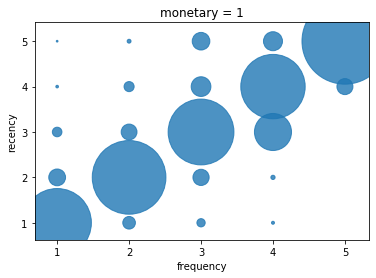

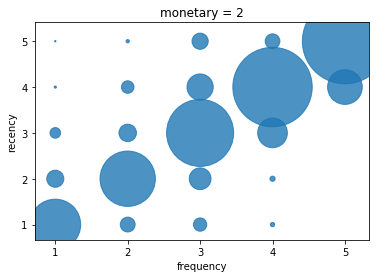

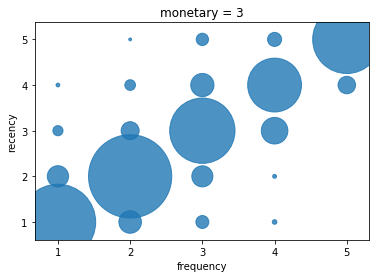

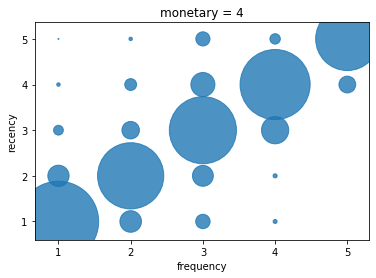

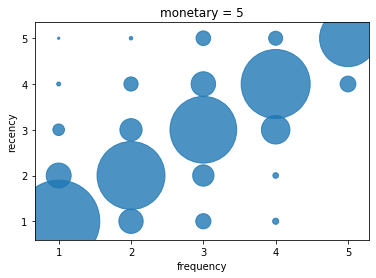

In [13]:
for z in range(1,6):
    subcells = cells[cells.monetary == z]
    plt.scatter(subcells['frequency'], subcells['recency'], s=subcells['householdid'], alpha=0.8)
    plt.xlabel('frequency')
    plt.ylabel('recency')
    plt.title('monetary = ' + str(z))
    plt.show()

Największe bąbelki znajdują się wzdłuż przekątnej, co pokazuje, że niedawność zakupu i częstotliwość są ściśle skorelowane. Dotyczy to szczególnie klientów, którzy dokonali tylko jednego zakupu. Jednorazowy, niedawny zakup oznacza, że częstotliwość jest dość wysoka. Jeśli zakup był dawno temu, częstotliwość jest dość niska. Na podstawie tych danych większość gospodarstw domowych dokonała tylko jednego zakupu, więc efekt ten jest dość zauważalny.

# Podsumowanie

Celem zastosowania metodologii takiej jak RFM jest identyfikacja klientów, którzy są bardziej skłonni do odpowiedzi, aby lepsi respondenci mogli zostać uwzględnieni w następnej kampanii.
Zazwyczaj najlepiej odpowiadające komórki to te w najlepszych pojemnikach, szczególnie w ostatnim czasie. Inne komórki mogą nie mieć szansy wykazania się jako posiadające cennych klientów.
Dla firm, które prowadzą kampanie marketingowe, w tym komórki testowe, jest bardzo korzystne i warte wysiłku w dłuższej perspektywie. Zapewniają one możliwość poznania klientów w dłuższej perspektywie.

# Literatura

[1] Data Analysis Using SQL and Excel, Gordon Linoff